# Reviewing rainfall levels by region for cyclone Chido

This notebook reviews how far from the rainfall trigger cyclone Chido was.

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.datasources import codab, imerg
from src.constants import *
from src import db_utils

In [4]:
adm1 = codab.load_codab(admin_level=1)

In [5]:
aoi_adm1_pcodes = adm1["ADM1_PCODE"].unique()
aoi_adm1_pcodes.shape

(22,)

In [6]:
# this is from Meteo-France site
landfall_df = pd.DataFrame(
    {
        "NAME": ["CHIDO"],
        "LON": [49.98],
        "LAT": [-11.21],
        "landfall_date": [pd.to_datetime("2024-12-13")],
    }
)
landfall_df

,NAME,LON,LAT,landfall_date
0,CHIDO,49.98,-11.21,2024-12-13


In [7]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
dfs = []
for sid, row in landfall_df.set_index("NAME").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["NAME"] = sid
    dfs.append(df_in)

In [8]:
end_date

Timestamp('2024-12-14 00:00:00')

In [9]:
imerg_df = pd.concat(dfs, ignore_index=True)
imerg_df

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,NAME
0,MDG,MG11,2024-12-12,1,0.061137,0.000000,0.000,10.594999,585,35.76500,0.758842,CHIDO
1,MDG,MG11,2024-12-13,1,0.009094,0.000000,0.000,0.890000,585,5.32000,0.089335,CHIDO
2,MDG,MG11,2024-12-14,1,2.085077,0.000000,0.000,48.690002,585,1219.77000,6.272464,CHIDO
3,MDG,MG12,2024-12-12,1,2.581969,0.000000,0.000,35.704998,617,1593.07500,5.470086,CHIDO
4,MDG,MG12,2024-12-13,1,0.103720,0.000000,0.000,4.110000,617,63.99500,0.547399,CHIDO
...,...,...,...,...,...,...,...,...,...,...,...,...
61,MDG,MG71,2024-12-13,1,13.465966,11.570001,3.055,53.214996,657,8847.14000,7.787168,CHIDO
62,MDG,MG71,2024-12-14,1,2.129757,1.415000,0.000,27.279999,657,1399.25000,2.340674,CHIDO
63,MDG,MG72,2024-12-12,1,0.741200,0.200000,0.000,11.065000,792,587.02997,1.106211,CHIDO
64,MDG,MG72,2024-12-13,1,18.836824,16.249998,0.690,67.165000,792,14918.76500,13.742192,CHIDO


In [10]:
adm_mean_sum = imerg_df.groupby("pcode")["mean"].sum().reset_index()
adm1_rain = adm1.merge(
    adm_mean_sum, left_on="ADM1_PCODE", right_on="pcode", how="left"
)

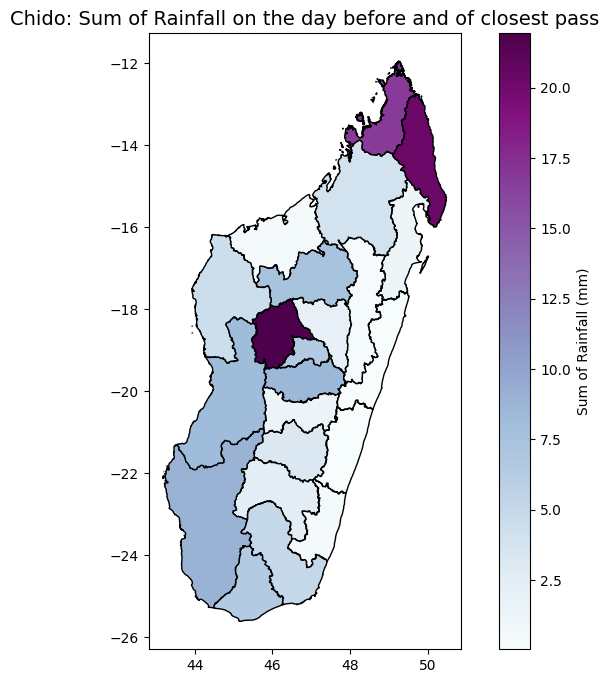

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

adm1_rain.plot(
    column="mean",
    cmap="BuPu",
    legend=True,
    legend_kwds={"label": "Sum of Rainfall (mm)"},
    edgecolor="black",
    ax=ax,
)
ax.set_title(
    "Cyclone Chido: Sum of Rainfall on the day before and of closest pass", fontsize=14
)
plt.show()